#TP4(Projet)

#imports

In [92]:
import time
import os
import yake
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Image


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Digit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
import sys
import re
from nltk.tokenize import sent_tokenize
import spacy
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

import shutil

In [94]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode
import collections
import string
import pandas as pd
from nltk import word_tokenize
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import nltk
from nltk.tokenize import sent_tokenize

In [95]:
# Instantier l'extracteur de mots clés
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

In [96]:
# Liste de Stopwords enrichis (Idem que dans s1)
sw = stopwords.words("french")
sw += ["abord","deux","tout", "ailleurs", "ainsi", "alors", "après", "avant", "avoir", "bien", "bientôt",
    "car", "ce", "ceci", "cela", "ces", "cet", "cette", "comme", "contre", "dans",
    "depuis", "dire", "doit", "donc", "elle", "encore", "enfin", "ensuite", "entre", "être",
    "fait", "faire", "faut", "hormis", "ici", "il", "ils", "jusqu'à", "les", "leur", "là",
    "ma", "mais", "mes", "moins", "mon", "ne", "non", "nous", "on", "ou", "ou bien", "par",
    "parce que", "parfois", "pas", "pendant", "peut", "plus", "plutôt", "pour", "puis",
    "quand", "quant à", "sans", "sa", "se", "ses", "son", "sous", "tant pis", "tandis que",
    "trois", "tôt ou tard", "toutefois", "toutes", "tu", "tous", "trois", "trois", "trois",
    "voilà", "à", "très"]
sw = set(sw)

In [97]:
data_path = "../data/txttp5/"

#Chemin vers les differents fichiers de notre travail 

In [98]:
files = [f for f in sorted(os.listdir(data_path)) if f.endswith('.txt')]

In [99]:
# taille des fichiers
files
len(files)

1001

In [100]:
# Exemple de fichiers
files[:5]

['KB_JB1051_1921-12-24_01-00004.txt',
 'KB_JB1051_1924-11-06_01-00004.txt',
 'KB_JB1051_1924-11-06_01-00005.txt',
 'KB_JB1051_1925-03-05_01-00004.txt',
 'KB_JB1051_1925-07-31_01-00002.txt']

In [101]:
# Stocker le contenu de ces fichiers dans une liste en utilisant la compréhension de liste
texts = [open(data_path + f, "r", encoding="utf-8").read() for f in files]

In [46]:

# Ecrire tout le contenu dans un fichier temporaire
temp_path = '../data/tmp'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
with open(os.path.join(temp_path, f'texts.txt'), 'w', encoding='utf-8') as f:
    f.write(' '.join(texts))


In [48]:
# Imprimer le contenu du fichier et constater les "déchets"
with open(os.path.join(temp_path, f'texts.txt'), 'r', encoding='utf-8') as f:
    before = f.read()

before[:500]

"\\ La Propagande Communiste parmi les Femmes La Fédération Bruxelloise du Parti s'est préoccupée récemment de la constitution, dans son sein, d'une commission spéciale chargée du travail d'organisation et de propagande parmi les femmes. Nous publions, in-extenso, l'intéressant et documenté rapport soumis par la camarade Kestemont, membre du Comité Central, à la réunion des membres féminins du Parti, tenue le 6 décembre 1921. Les différentes fédérations du pays voudront sans aucun doute s'inspirer"

In [49]:
def clean_text(folder=None):
    if folder is None:
        input_path = f"texts.txt"
        output_path = f"texts_clean.txt"
    else:
        input_path = f"{folder}/texts.txt"
        output_path = f"{folder}/texts_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, 'r', encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.upper() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [50]:
clean_text( folder=temp_path)

'Output has been written in ../data/tmp/texts_clean.txt!'

In [51]:
# Vérifier le résultat
with open(os.path.join(temp_path, f'texts_clean.txt'), 'r', encoding='utf-8') as f:
    after = f.read()

after[:500]

'PROPAGANDE COMMUNISTE PARMI FEMMES FÉDÉRATION BRUXELLOISE PARTI PRÉOCCUPÉE RÉCEMMENT CONSTITUTION SEIN COMMISSION SPÉCIALE CHARGÉE TRAVAIL ORGANISATION PROPAGANDE PARMI FEMMES PUBLIONS EXTENSO INTÉRESSANT DOCUMENTÉ RAPPORT SOUMIS CAMARADE KESTEMONT MEMBRE COMITÉ CENTRAL RÉUNION MEMBRES FÉMININS PARTI TENUE DÉCEMBRE DIFFÉRENTES FÉDÉRATIONS PAYS VOUDRONT AUCUN DOUTE INSPIRER TRAVAIL DÉVELOPPEMENT ORGANISATION COMMUNISTE PARMI FEMMES CHÈRES CAMARADES VAIL GROPAGANDE PARMI FEMMES COMMUNISTES SECTION'

#  Extraire uniquement les phrases "pertinentes" dans les documents

In [52]:
query = ["Femmes", "droits femmes","droits"]


In [53]:
# Création d'une regex afin de trouver les mots de la liste query dans le texte
regex = re.compile(f"\\b({'|'.join(query)})\\b", re.IGNORECASE)

In [54]:
# Le répertoire qui contient vos fichiers txt exportés de Camille
indir = "../data/tmp/"
# Le répertoire qui contiendra les fichiers txt nettoyés
outdir = "../data/tmp/regex/"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [55]:
for file in os.listdir(indir)[:10]:
    if file.endswith("texts_clean.txt"):
        relevant_sentences = []
        f_in = open(os.path.join(indir, file), encoding="utf-8")
        text = f_in.read()
        for sentence in sent_tokenize(text):
            if regex.search(sentence):
                relevant_sentences.append(sentence)
        f_in.close()
        f_out = open(os.path.join(outdir, file), "w", encoding="utf-8")
        f_out.write("\n\n".join(relevant_sentences))
        f_out.close()

In [56]:
# Vérifier le résultat
with open(os.path.join(outdir, f'texts_clean.txt'), 'r', encoding='utf-8') as f:
    after = f.read()

after[:500]

'PROPAGANDE COMMUNISTE PARMI FEMMES FÉDÉRATION BRUXELLOISE PARTI PRÉOCCUPÉE RÉCEMMENT CONSTITUTION SEIN COMMISSION SPÉCIALE CHARGÉE TRAVAIL ORGANISATION PROPAGANDE PARMI FEMMES PUBLIONS EXTENSO INTÉRESSANT DOCUMENTÉ RAPPORT SOUMIS CAMARADE KESTEMONT MEMBRE COMITÉ CENTRAL RÉUNION MEMBRES FÉMININS PARTI TENUE DÉCEMBRE DIFFÉRENTES FÉDÉRATIONS PAYS VOUDRONT AUCUN DOUTE INSPIRER TRAVAIL DÉVELOPPEMENT ORGANISATION COMMUNISTE PARMI FEMMES CHÈRES CAMARADES VAIL GROPAGANDE PARMI FEMMES COMMUNISTES SECTION'

### Afficher les termes les plus fréquents


In [57]:
frequencies = Counter(after.split())
print(frequencies.most_common(20))

[('FEMMES', 7309), ('DONT', 7119), ('RUE', 6717), ('BRUXELLES', 6315), ('DIT', 6165), ('HEURES', 5606), ('LEURS', 5332), ('AUSSI', 5110), ('GOUVERNEMENT', 5052), ('ANS', 4990), ('GRAND', 4878), ('FEMME', 4832), ('JOUR', 4710), ('DROIT', 4324), ('PEU', 4314), ('MINISTRE', 4282), ('AUTRE', 4210), ('QUELQUES', 4210), ('PAYS', 4126), ('AUTRES', 4115)]


# Nuage de mots

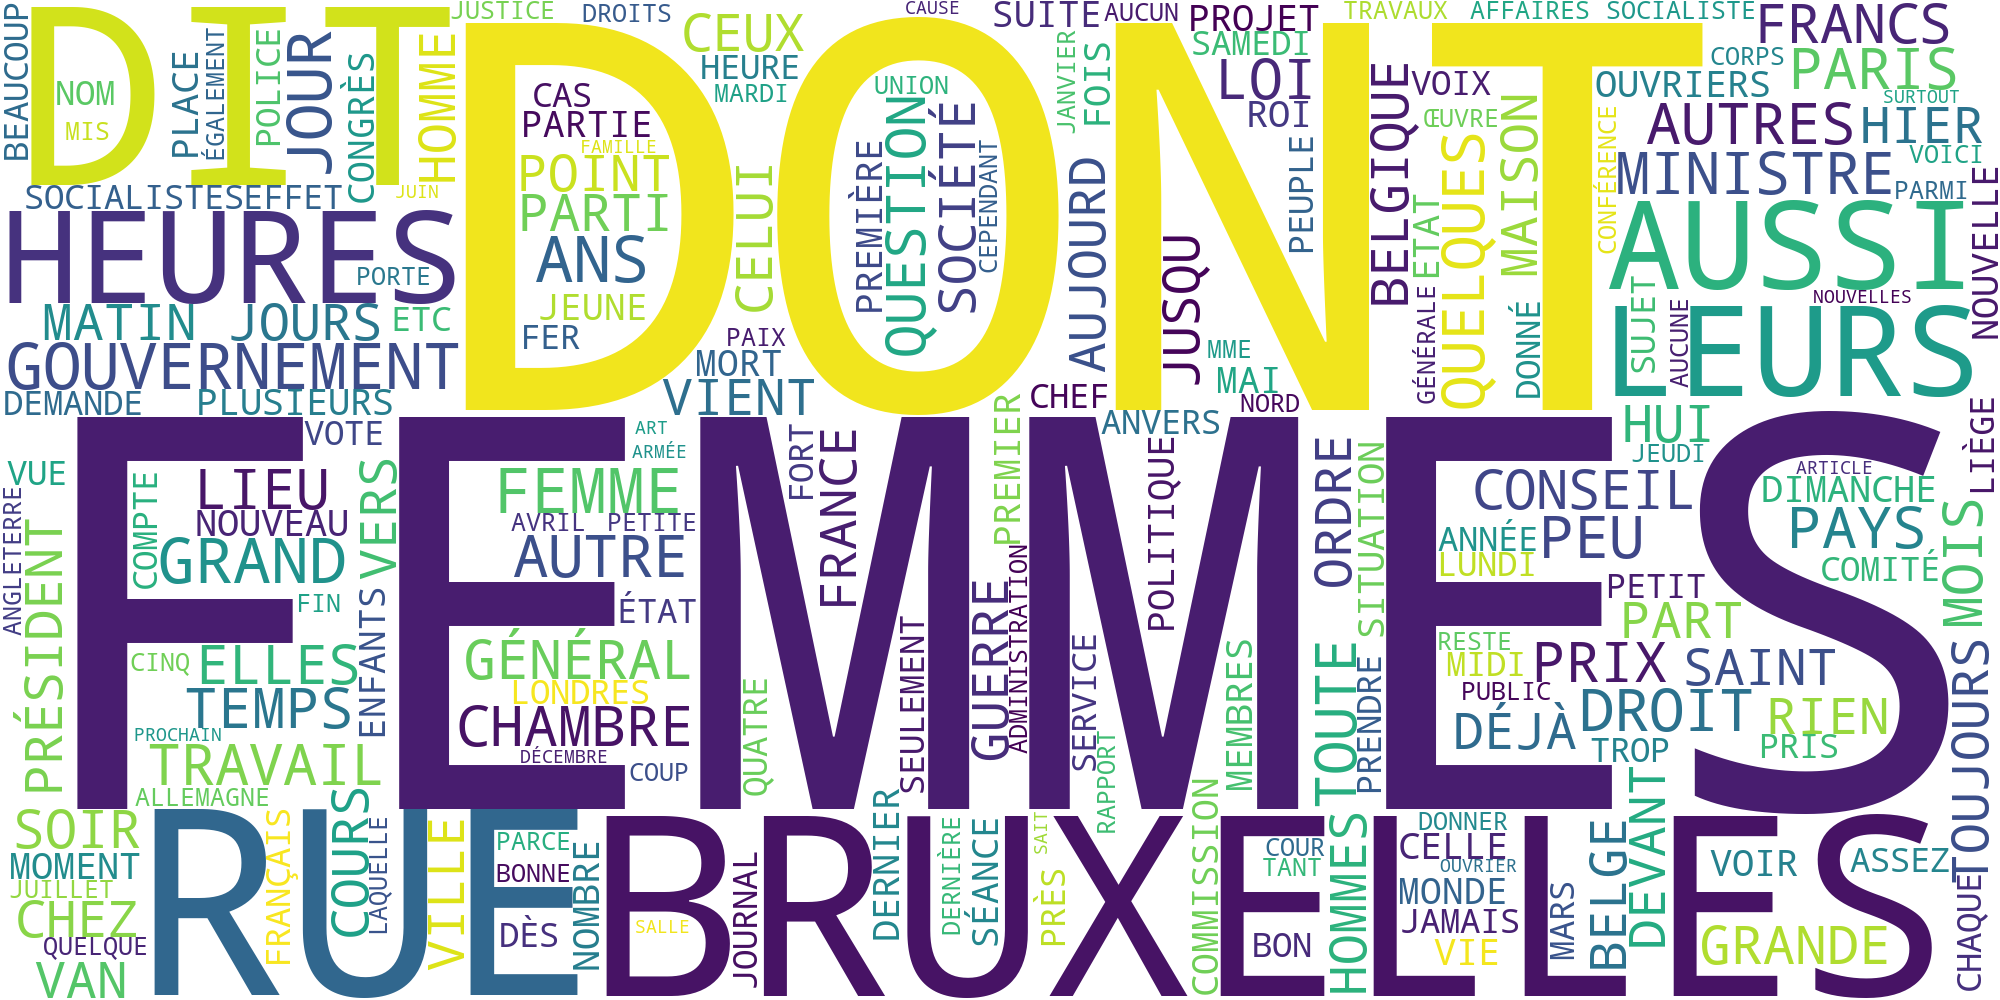

In [58]:
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, f"texts.png"))
Image(filename=os.path.join(temp_path, f"texts.png"))

In [ ]:
this_file = files
this_file

In [64]:
# Initialisation de liste pour stocker les textes
texts_n = []

# Parcourir la liste des noms de fichiers
for this_file in this_file:
    file_path = os.path.join(data_path, this_file)
    
    # Vérifier si le fichier existe
    if os.path.exists(file_path):
        # Lecture du contenu du fichier et stockage dans la liste
        with open(file_path, 'r', encoding='utf-8') as file:
            file_text = file.read()
            texts_n.append(file_text)

In [ ]:
# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(file_text)
keywords

In [ ]:
# Ne garder que les bigrammes
kept = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2:
        kept.append(kw)
kept

# Entités Nommées

In [8]:
import spacy
from collections import defaultdict
from multiprocessing import Pool, cpu_count

# Initialiser le modèle SpaCy pour le français
nlp = spacy.load("fr_core_news_lg")

# Fonction pour traiter un morceau de texte
def process_text(text_chunk):
    doc = nlp(text_chunk)
    people = defaultdict(int)
    locations = defaultdict(int)
    organizations = defaultdict(int)
    dates = defaultdict(int)
    
    for ent in doc.ents:
        if ent.label_ == "PER" and len(ent.text) > 3:
            people[ent.text] += 1
        elif ent.label_ == "LOC":
            locations[ent.text] += 1
        elif ent.label_ == "ORG":
            organizations[ent.text] += 1
        elif ent.label_ == "DATE":
            dates[ent.text] += 1
    
    return people, locations, organizations, dates

# Charger le texte
n = 1000000  # Augmenté pour traiter un plus grand volume de texte
text = open("../data/tmp/regex/texts_clean.txt", encoding='utf-8').read()[:n]

# Diviser le texte en morceaux pour le traitement parallèle
num_chunks = cpu_count()
chunk_size = len(text) // num_chunks
text_chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

# Traiter les morceaux de texte en parallèle
with Pool(processes=num_chunks) as pool:
    results = pool.map(process_text, text_chunks)

# Combiner les résultats des différents morceaux
combined_people = defaultdict(int)
combined_locations = defaultdict(int)
combined_organizations = defaultdict(int)
combined_dates = defaultdict(int)

for people, locations, organizations, dates in results:
    for k, v in people.items():
        combined_people[k] += v
    for k, v in locations.items():
        combined_locations[k] += v
    for k, v in organizations.items():
        combined_organizations[k] += v
    for k, v in dates.items():
        combined_dates[k] += v

# Trier et imprimer les personnes
sorted_people = sorted(combined_people.items(), key=lambda kv: kv[1], reverse=True)
print("\nPersonnes les plus mentionnées :")
for person, freq in sorted_people[:50]:
    print(f"{person} apparait {freq} fois dans le corpus")

# Trier et imprimer les lieux
sorted_locations = sorted(combined_locations.items(), key=lambda kv: kv[1], reverse=True)
print("\nLieux les plus mentionnés :")
for location, freq in sorted_locations[:50]:
    print(f"{location} apparait {freq} fois dans le corpus")

# Trier et imprimer les organisations
sorted_organizations = sorted(combined_organizations.items(), key=lambda kv: kv[1], reverse=True)
print("\nOrganisations les plus mentionnées :")
for organization, freq in sorted_organizations[:50]:
    print(f"{organization} apparait {freq} fois dans le corpus")

# Trier et imprimer les dates
sorted_dates = sorted(combined_dates.items(), key=lambda kv: kv[1], reverse=True)
print("\nDates les plus mentionnées :")
for date, freq in sorted_dates[:50]:
    print(f"{date} apparait {freq} fois dans le corpus")


# Clustering 

## Vectoriser les documents à l'aide de TF-IDF

In [102]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [103]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [ ]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [ ]:
# Détail de la matrice
tfidf_vectors

### Imprimer le vecteur tf-IDF du premier document

In [106]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

communiste     0.312336
communistes    0.302354
sections       0.240222
ouvrières      0.188520
fédération     0.173835
                 ...   
faisant        0.000000
fallait        0.000000
fallu          0.000000
fameuse        0.000000
♦              0.000000
Length: 3698, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [ ]:
cosine([1, 2, 3], [1, 2, 3])

In [ ]:
cosine([1, 2, 3], [1, 2, 2])

In [ ]:
cosine([1, 2, 3], [2, 2, 2])

### Tests sur nos documents

In [110]:
tfidf_array = tfidf_vectors.toarray()

In [ ]:
# Vecteur du document 0
tfidf_array[0]

In [112]:
# Vecteur du document 1
tfidf_array[1]

array([0.        , 0.01721514, 0.        , ..., 0.        , 0.02251518,
       0.        ])

In [113]:
cosine(tfidf_array[0], tfidf_array[1])

0.625300340688581

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

### Définir un nombre de clusters

In [114]:
N_CLUSTERS = 5

### Instancier le modèle K-Means et ses arguments

In [115]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [ ]:
clusters = km_model.fit_predict(tfidf_vectors)

In [117]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [ ]:
pprint(dict(clustering))

In [81]:
from timeout_decorator import timeout, TimeoutError

In [ ]:
import os
from threading import Timer
from pprint import pprint

# Lecture du contenu des fichiers avec une limite de temps
def read_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

# Gestion du délai d'exécution
def timeout_handler():
    raise TimeoutError("Function execution timed out")

# Exploration des données brutes de chaque cluster
for cluster_label, files_in_cluster in clustering.items():
    print(f"Cluster {cluster_label} :")
    # pprint(files_in_cluster)
    print("\n")

    content_list = []
    for txt in files_in_cluster:
        timer = Timer(5, timeout_handler)
        try:
            timer.start()
            content = read_file_content(os.path.join(data_path, txt))
            content_list.append(content)
        except TimeoutError:
            print(f"Reading {txt} took too long. Skipping.")
            continue
        finally:
            timer.cancel()

    # Afficher le contenu de chaque texte dans le cluster
    for txt, content in zip(files_in_cluster, content_list):
        print(f"Text in Cluster {cluster_label}: {txt}")
        print(content)
        print("\n")


In [ ]:
# Stockage du contenu de chaque cluster dans une liste
all_cluster_content = []

# Exploration des données brutes de chaque cluster
for cluster_label, files_in_cluster in clustering.items():
   

    
    cluster_content = ""
    for txt in files_in_cluster:
        try:
            content = read_file_content(os.path.join(data_path, txt))
            cluster_content += content + "\n"  
        except TimeoutError:
            print(f"Reading {txt} took too long. Skipping.")

    # Ajouter le contenu du cluster au corpus global
    all_cluster_content.append(cluster_content)

# Afficher le contenu de chaque cluster
for cluster_label, cluster_content in zip(clustering.keys(), all_cluster_content):
    print(f"Cluster {cluster_label} - All Content:")
    print(cluster_content)
    print("\n")

### Extraction de keywords des differents clusters 

In [ ]:
from rake_nltk import Rake

# Initialiser l'extracteur de mots-clés
kw_extractor = Rake()

all_cluster_keywords = []

for cluster_label, files_in_cluster in clustering.items():
    cluster_content = ""
    for txt in files_in_cluster:
        try:
            content = read_file_content(os.path.join(data_path, txt))
            cluster_content += content + "\n"  # Concaténer le contenu des textes avec un saut de ligne
        except TimeoutError:
            print(f"Reading {txt} took too long. Skipping.")

    # Extraction des mots-clés du contenu du cluster
    kw_extractor.extract_keywords_from_text(cluster_content)
    cluster_keywords = kw_extractor.get_ranked_phrases()

    all_cluster_keywords.append(cluster_keywords)

# Affichage des mots-clés de chaque cluster
for cluster_label, cluster_keywords in zip(clustering.keys(), all_cluster_keywords):
    print(f"Cluster {cluster_label} - Keywords:")
    pprint(cluster_keywords)
    print("\n")


## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [119]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [ ]:
reduced_vectors[:10]

### Générer le plot

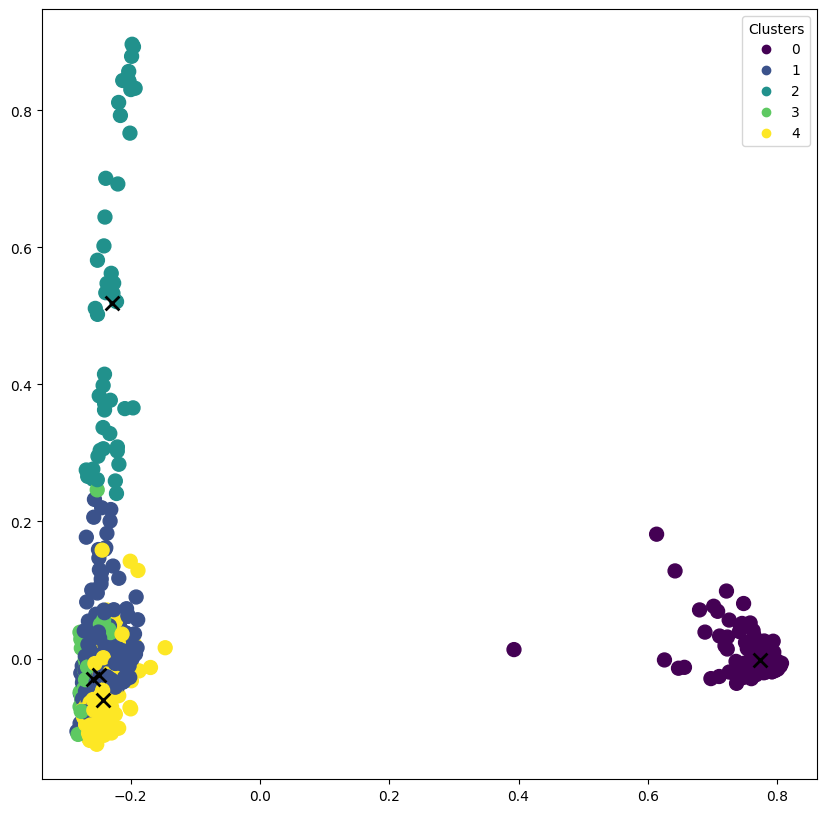

In [121]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")